In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

In [126]:
def single_component_mse(inputs, targets, component : int):
    return torch.sum((inputs[..., component] - targets[..., component])**2) / inputs[..., component].nelement()

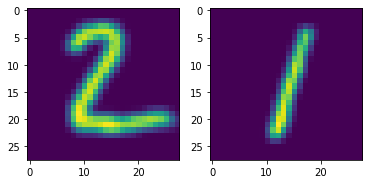

In [127]:
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [3, 3]) / 255.

img1 = imgdata[1]
img2 = imgdata[2]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.show()

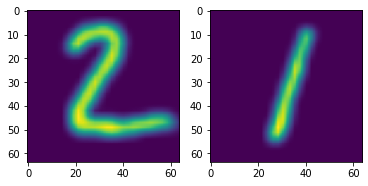

In [128]:
k = 64
f = SingleChannelImageSurface(img1)
g = SingleChannelImageSurface(img2)


XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.show()

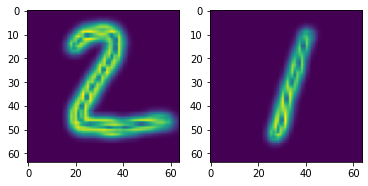

In [129]:
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.show()

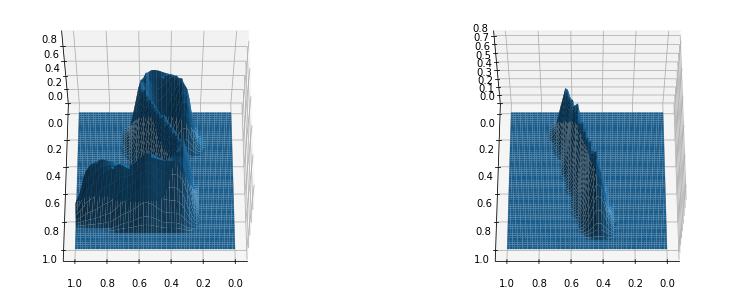

In [130]:
%matplotlib inline
# Init Figure 
fig = plt.figure(figsize=(12, 4))
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
plt.show(fig)

In [131]:
# Define reparametrization-network
RN = ReparametrizationNetwork2D(5, 5, layer_type=PalaisLayer)
optimizer = torch.optim.SGD(RN.parameters(), lr=1e-3, momentum=0.9)
epsilon=1e-2
delta=1e-3

for i in range(101):
    optimizer.zero_grad()
    Y, U = RN(X)
    Q = q(X)
    R = torch.sqrt(U) * r(Y)
    
    # Compute loss, and perform a backward pass and gradient step
    l = single_component_mse(Q, R, 2)
#     l = torch.nn.functional.mse_loss(Q, R)
    l.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        Y = X
        for layer in RN.layers:
            layer.project(Y, epsilon, delta)
            Y, _ = layer(Y)

    if i % 10 == 0:
        print(f"{i:5d} - loss: {l:>.10f}")
    

    0 - loss: 0.5548288226
   10 - loss: 0.4075649083
   20 - loss: 0.3123271763
   30 - loss: 0.2671150863
   40 - loss: 0.2483119369
   50 - loss: 0.2378557920
   60 - loss: 0.2300170362
   70 - loss: 0.2044831961
   80 - loss: 0.1973786503
   90 - loss: 0.2173963636
  100 - loss: 0.1887346506


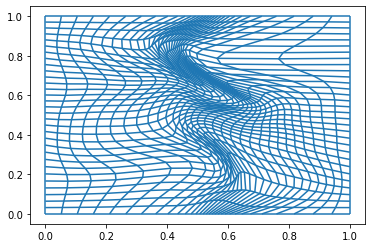

In [132]:
u = lambda x: RN(x)[0]
plot_diffeomorphism(u, k=32)

fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

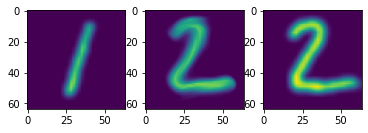

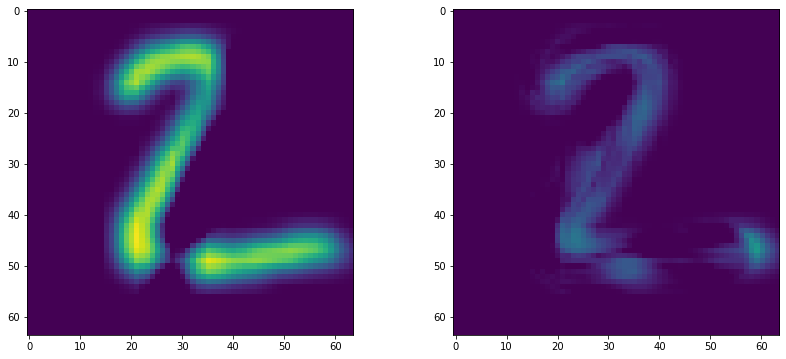

In [133]:
Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
# plot_diffeomorphism(k=32, ax=ax2)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(Zf[2] - Zg[2], vmin=0., vmax=1.)
# plot_diffeomorphism(u, k=32, ax=ax2)
ax3.imshow(Zf[2] - Zgg[..., 2], vmin=0., vmax=1.)
plt.show()

### Distance Matrix Compute

In [117]:
def fit(q, r, RN, X, iters, optimizer_constructor, epsilon, delta, verbose=1):
    for i in range(iters):
        optimizer.zero_grad()
        Y, U = RN(X)
        Q = q(X)
        R = torch.sqrt(U) * r(Y)

        # Compute loss, and perform a backward pass and gradient step
#         l = single_component_mse(Q, R, 2)
        l = torch.nn.functional.mse_loss(Q, R)

        l.backward()
        optimizer.step()

        with torch.no_grad():
            Y = X
            for layer in RN.layers:
                layer.project(Y, epsilon, delta)
                Y, _ = layer(Y)

        if i % 10 == 0 and verbose >= 2:
            print(f"{i:5d} - loss: {l:>.10f}")
            
    if verbose >= 1:
        print(f"Final loss: {l:>.10f}")

    return l.item()

In [118]:
def optimizer_builder(optimizer, *args, **kwargs):
    return lambda network: optimizer(network.parameters(), *args, **kwargs)

In [119]:
examples_per_digit = 2
digits = torch.empty(10 *  examples_per_digit, 28, 28)

for i in range(10):
    start = i * examples_per_digit
    digits[start:start+examples_per_digit] = imgdata[labels == i][:examples_per_digit]

In [120]:
optim_builder = optimizer_builder(torch.optim.SGD, lr=1e-3, momentum=0.9)
# Define reparametrization-network
epsilon=1e-2
delta=1e-3

num_images = digits.shape[0]

distance_matrix = np.zeros((num_images, num_images))

for i in range(digits.shape[0]):
    print(f"{'=' * 30 } Digit {labels[i]} {'=' * 30}")
    f = SingleChannelImageSurface(digits[i])
    q = Qmap(f)
    for j in range(digits.shape[0]):
        if i == j:
            continue
        g = SingleChannelImageSurface(digits[j])
        r = Qmap(g)
        RN = ReparametrizationNetwork2D(5, 5, layer_type=PalaisLayer)
        optimizer = optim_builder(RN)
        
        print(f"{'-'*20} Comparing digits {labels[i]} and {labels[j]} {'-'*20}")
        distance_matrix[i, j] = fit(q, r, RN, X, 25, optimizer, 1e-2, 1e-3, verbose=2)
        
        

============================== Digit 0 ==============================
-------------------- Comparing digits 0 and 2 --------------------
    0 - loss: 0.3195581436
   10 - loss: 0.1792718768
   20 - loss: 0.0845772699
Final loss: 0.0885573104
-------------------- Comparing digits 0 and 1 --------------------
    0 - loss: 0.4581925869
   10 - loss: 0.2972119749
   20 - loss: 0.2837290764
Final loss: 0.2629542053
-------------------- Comparing digits 0 and 0 --------------------
    0 - loss: 0.4599551260
   10 - loss: 0.2358924896
   20 - loss: 0.2283556014
Final loss: 0.1963537186
-------------------- Comparing digits 0 and 4 --------------------
    0 - loss: 0.4376462698
   10 - loss: 0.2956981361
   20 - loss: 0.1943745762
Final loss: 0.1548908800
-------------------- Comparing digits 0 and 1 --------------------
    0 - loss: 0.4120241106
   10 - loss: 0.1867663413
   20 - loss: 0.1683913916
Final loss: 0.1438616365
-------------------- Comparing digits 0 and 4 -------------------

   10 - loss: 0.2167190909
   20 - loss: 0.1959462762
Final loss: 0.1674757451
-------------------- Comparing digits 2 and 0 --------------------
    0 - loss: 0.3618761003
   10 - loss: 0.3509099185
   20 - loss: 0.2901487052
Final loss: 0.2719616592
-------------------- Comparing digits 2 and 6 --------------------
    0 - loss: 0.3443702459
   10 - loss: 0.2786000073
   20 - loss: 0.1994485110
Final loss: 0.1793884039
-------------------- Comparing digits 2 and 9 --------------------
    0 - loss: 0.3415819108
   10 - loss: 0.3081625998
   20 - loss: 0.3155332208
Final loss: 0.2623462379
-------------------- Comparing digits 2 and 0 --------------------
    0 - loss: 0.3101863563
   10 - loss: 0.3391243219
   20 - loss: 0.2791344821
Final loss: 0.2512951493
-------------------- Comparing digits 2 and 1 --------------------
    0 - loss: 0.2629674077
   10 - loss: 0.1399214715
   20 - loss: 0.1250855923
Final loss: 0.1168271527
-------------------- Comparing digits 2 and 5 ----------

   10 - loss: 0.2505504787
   20 - loss: 0.1941128820
Final loss: 0.1601281315
-------------------- Comparing digits 4 and 4 --------------------
    0 - loss: 0.5552585721
   10 - loss: 0.2981088459
   20 - loss: 0.2520957589
Final loss: 0.2077249885
============================== Digit 5 ==============================
-------------------- Comparing digits 5 and 7 --------------------
    0 - loss: 0.4120241106
   10 - loss: 0.2003517002
   20 - loss: 0.1784001589
Final loss: 0.1557938755
-------------------- Comparing digits 5 and 2 --------------------
    0 - loss: 0.3284813464
   10 - loss: 0.1914454699
   20 - loss: 0.1231139004
Final loss: 0.1284746677
-------------------- Comparing digits 5 and 1 --------------------
    0 - loss: 0.4149069786
   10 - loss: 0.2820871770
   20 - loss: 0.2398995161
Final loss: 0.2365893126
-------------------- Comparing digits 5 and 0 --------------------
    0 - loss: 0.4575270116
   10 - loss: 0.2808186412
   20 - loss: 0.2098685354
Final loss:

   20 - loss: 0.1621080637
Final loss: 0.1651326567
-------------------- Comparing digits 7 and 5 --------------------
    0 - loss: 0.3841893673
   10 - loss: 0.2478986382
   20 - loss: 0.1666785032
Final loss: 0.1781602055
-------------------- Comparing digits 7 and 9 --------------------
    0 - loss: 0.3135177195
   10 - loss: 0.2558406293
   20 - loss: 0.1626327485
Final loss: 0.1518141776
-------------------- Comparing digits 7 and 0 --------------------
    0 - loss: 0.4319101572
   10 - loss: 0.3127524555
   20 - loss: 0.2309274226
Final loss: 0.2209614515
-------------------- Comparing digits 7 and 6 --------------------
    0 - loss: 0.3263329566
   10 - loss: 0.1708886623
   20 - loss: 0.1235842183
Final loss: 0.1189138517
-------------------- Comparing digits 7 and 9 --------------------
    0 - loss: 0.3704872131
   10 - loss: 0.2561523616
   20 - loss: 0.2197988033
Final loss: 0.1846490055
-------------------- Comparing digits 7 and 0 --------------------
    0 - loss: 0.

   10 - loss: 0.2749212086
   20 - loss: 0.1618377715
Final loss: 0.1421567947
-------------------- Comparing digits 9 and 7 --------------------
    0 - loss: 0.2355211526
   10 - loss: 0.1523154080
   20 - loss: 0.1098760962
Final loss: 0.1198922992
-------------------- Comparing digits 9 and 3 --------------------
    0 - loss: 0.3570946753
   10 - loss: 0.1657079607
   20 - loss: 0.1120298132
Final loss: 0.1089851037
-------------------- Comparing digits 9 and 4 --------------------
    0 - loss: 0.3053840697
   10 - loss: 0.1824076325
   20 - loss: 0.1280815452
Final loss: 0.1114976332
============================== Digit 10 ==============================
-------------------- Comparing digits 10 and 7 --------------------
    0 - loss: 0.4140187800
   10 - loss: 0.1973113865
   20 - loss: 0.1101951823
Final loss: 0.1230485365
-------------------- Comparing digits 10 and 2 --------------------
    0 - loss: 0.4173686802
   10 - loss: 0.3357268870
   20 - loss: 0.2987879813
Final lo

   10 - loss: 0.2999542952
   20 - loss: 0.2074230909
Final loss: 0.1755344421
-------------------- Comparing digits 12 and 1 --------------------
    0 - loss: 0.3942976296
   10 - loss: 0.2440394163
   20 - loss: 0.1751798242
Final loss: 0.1565418094
-------------------- Comparing digits 12 and 4 --------------------
    0 - loss: 0.3994209766
   10 - loss: 0.2574099600
   20 - loss: 0.2044415623
Final loss: 0.2003339082
-------------------- Comparing digits 12 and 9 --------------------
    0 - loss: 0.3704872131
   10 - loss: 0.2405356020
   20 - loss: 0.1627980918
Final loss: 0.1472364515
-------------------- Comparing digits 12 and 5 --------------------
    0 - loss: 0.2784596086
   10 - loss: 0.1738278866
   20 - loss: 0.1373968273
Final loss: 0.1292897463
-------------------- Comparing digits 12 and 9 --------------------
    0 - loss: 0.3098546565
   10 - loss: 0.1726118773
   20 - loss: 0.1468957812
Final loss: 0.1430888325
-------------------- Comparing digits 12 and 0 ----

Final loss: 0.1779532284
-------------------- Comparing digits 14 and 0 --------------------
    0 - loss: 0.3739341199
   10 - loss: 0.2652789354
   20 - loss: 0.2786497772
Final loss: 0.2148793340
-------------------- Comparing digits 14 and 5 --------------------
    0 - loss: 0.1029497758
   10 - loss: 0.0406293236
   20 - loss: 0.0435215384
Final loss: 0.0418194681
-------------------- Comparing digits 14 and 9 --------------------
    0 - loss: 0.3637942374
   10 - loss: 0.2737077773
   20 - loss: 0.1861198395
Final loss: 0.1611516029
-------------------- Comparing digits 14 and 7 --------------------
    0 - loss: 0.3614701033
   10 - loss: 0.2262040973
   20 - loss: 0.2393110245
Final loss: 0.1993415207
-------------------- Comparing digits 14 and 3 --------------------
    0 - loss: 0.3914917409
   10 - loss: 0.2499998063
   20 - loss: 0.1661997885
Final loss: 0.1637249291
-------------------- Comparing digits 14 and 4 --------------------
    0 - loss: 0.2465081811
   10 - lo

Final loss: 0.2012552470
-------------------- Comparing digits 17 and 1 --------------------
    0 - loss: 0.3127920926
   10 - loss: 0.2437866181
   20 - loss: 0.2228848487
Final loss: 0.2055405974
-------------------- Comparing digits 17 and 0 --------------------
    0 - loss: 0.3036997020
   10 - loss: 0.2345409244
   20 - loss: 0.2199589610
Final loss: 0.1693137884
-------------------- Comparing digits 17 and 4 --------------------
    0 - loss: 0.4426226616
   10 - loss: 0.2891465127
   20 - loss: 0.2348533273
Final loss: 0.1988229603
-------------------- Comparing digits 17 and 1 --------------------
    0 - loss: 0.3919087350
   10 - loss: 0.2447615862
   20 - loss: 0.1553089172
Final loss: 0.1593341231
-------------------- Comparing digits 17 and 4 --------------------
    0 - loss: 0.4191983938
   10 - loss: 0.3072623014
   20 - loss: 0.1864703149
Final loss: 0.1875040978
-------------------- Comparing digits 17 and 9 --------------------
    0 - loss: 0.3670874536
   10 - lo

   10 - loss: 0.2769890726
   20 - loss: 0.1876106262
Final loss: 0.1582064480
-------------------- Comparing digits 19 and 6 --------------------
    0 - loss: 0.4591039717
   10 - loss: 0.2708425820
   20 - loss: 0.2377947718
Final loss: 0.2301239222
-------------------- Comparing digits 19 and 9 --------------------
    0 - loss: 0.3441519439
   10 - loss: 0.2527908385
   20 - loss: 0.1735249907
Final loss: 0.1642288715
-------------------- Comparing digits 19 and 0 --------------------
    0 - loss: 0.3694896400
   10 - loss: 0.2601100504
   20 - loss: 0.1749720722
Final loss: 0.1725428104
-------------------- Comparing digits 19 and 1 --------------------
    0 - loss: 0.2465081811
   10 - loss: 0.1347852796
   20 - loss: 0.0997729897
Final loss: 0.0830579251
-------------------- Comparing digits 19 and 5 --------------------
    0 - loss: 0.3345842063
   10 - loss: 0.1382803768
   20 - loss: 0.1169135794
Final loss: 0.0746246576
-------------------- Comparing digits 19 and 9 ----

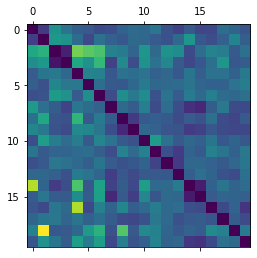

In [121]:
plt.matshow(distance_matrix)

In [122]:
np.save("distane_matrix2.npy", distance_matrix)